<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/week3/seminar_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

In this lecture we will get insight into very popular NLP task - Named Entity Recognition.<br>Our goal is to:
- build a good baseline solution
- modify the data markup
- learn how to solve this problem using neural network methods.

In first part we will explore how to get fast solution of this task, how to exlore metrics and how to convert labeling.<br>
In the second part we will look how we can solve this task by using different architectures and measure them.

What we will learn:
- non neural approaches for NER-task;
- measure quality of model for NER-task;
- different markup for NER-task;
- data preparation for neural network solution of NER;
- using different neural approaches for NER;

# Part 1

## Solving NER task without Neural netowrks

In [103]:
!pip install datasets > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.9.2 requires huggingface-hub==0.0.12, but you have huggingface-hub 0.0.19 which is incompatible.


In [104]:
import pytest
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional
from torch.utils.data import Dataset
from torch.optim import Adam
import time
from tqdm import tqdm

from collections import Counter
from sklearn.metrics import classification_report

### look at the data

For this task we will use common NER-dataset which is always included in all benchmarks, when scientists measure quality of SOTA solutions for NER.<br>
The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on four types of named entities: persons, locations, organizations and names of miscellaneous entities that do not belong to the previous three groups.

In [105]:
dataset_base = load_dataset("conll2003")

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [106]:
dataset_base['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [187]:
import json
mapping_ = {v: k for k, v in dataset_base["train"]\
            .features["ner_tags"].feature._str2int.items()}

with open('mapping.json', 'w') as f:
  json.dump(mapping_, f)
mapping_

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [108]:
for i in range(10):
  print(i + 1, ' '.join(dataset_base["train"]['tokens'][i]))

1 EU rejects German call to boycott British lamb .
2 Peter Blackburn
3 BRUSSELS 1996-08-22
4 The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
5 Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .
6 " We do n't support any such recommendation because we do n't see any grounds for it , " the Commission 's chief spokesman Nikolaus van der Pas told a news briefing .
7 He said further scientific study was required and if it was found that action was needed it should be taken by the European Union .
8 He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains , spleens and spinal cords from the human and animal food chains was a highly specific and precautionary move

#### Task 1

Count occurence of each entity. Print number of occurences for each entity. Result must be a dictinary, where keys are entities from `dataset_base["train"]['ner_tags']` and values are total number of occurencies for each key.

In [109]:
from collections import defaultdict
# counter = defaultdict()

In [110]:
%%time
from collections import defaultdict

counter = defaultdict(int)
for tags in dataset_base["train"]['ner_tags']:
  for tag in tags:
    counter[mapping_[tag]] += 1
counter

CPU times: user 151 ms, sys: 2 ms, total: 153 ms
Wall time: 152 ms


In [111]:
# %%time
# from collections import Counter
# lol = dataset_base["train"]['ner_tags']
# counter = Counter([mapping_[item] for sublist in lol for item in sublist])

# counter

In [112]:
assert len(counter) == 9
assert counter['O'] > 169000

In [113]:
counter

defaultdict(int,
            {'B-LOC': 7140,
             'B-MISC': 3438,
             'B-ORG': 6321,
             'B-PER': 6600,
             'I-LOC': 1157,
             'I-MISC': 1155,
             'I-ORG': 3704,
             'I-PER': 4528,
             'O': 169578})

As you see, we have dominating number of class `O`. Our main goal is to make such model, that will not overfit to predict always `O` token.<br>
What metrics are more appropriate to measure quality of models for NER?

### Sklearn-crf

Now I'd like to introduce you great library, that can provide light and easy implementation for solving NER-task. It's name is `sklearn-crf`. It has familiar interface to basic sklearn, but is based on very powerful tool for NER-task - CRF(Conditional Random Field). <br>
CRF is nowdays the de facto standard for solving the NLP problem. Even in the most modern SOTA neural networks approaches, a CRF layer can now often be seen as an output layer.

In [114]:
!pip install sklearn_crfsuite > /dev/null

In [115]:
import sklearn
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

As all sklearn-like libraries we need to get pandas.DataFrame as an input for this model. Let's create it.<br>
In our DataFrame we will make each word, entity and sentence_id on each row.

In [116]:
df = pd.DataFrame({'sent_id': [i for j in [[i] * len(s['tokens']) for i, s in enumerate(dataset_base['train'])] for i in j],
                   'data': [i for j in dataset_base['train'] for i in j['tokens']],
                   'entities': [mapping_[i] for j in dataset_base['train'] for i in j['ner_tags']]})
df.head(3)

,sent_id,data,entities
0,0,EU,B-ORG
1,0,rejects,O
2,0,German,B-MISC


Now we have dataframe, where only 3 columns exsists:
 - sentense_id - which mark each word belonging to each sentence
 - data contains words on each row
 - entities marks which entity does each word refer to.

We also need a class, that will process each sentence and aggregate words and entities in it

In [117]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['data'].values.tolist(), 
                                                     s['entities'].values.tolist())]
        self.grouped = self.data.groupby('sent_id').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [118]:
getter = SentenceGetter(df)
sentences = getter.sentences
sentences[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [119]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [120]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
len(X)

14041

In [121]:
X_train = X[:10000]
X_test = X[10000:]
y_train = y[:10000]
y_test = y[10000:]

In [122]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True
)
crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 10000/10000 [00:00<00:00, 13963.76it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 2954
Seconds required: 0.085

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.22  loss=173256.49 active=2930  feature_norm=1.00
Iter 2   time=0.25  loss=132654.60 active=2796  feature_norm=3.04
Iter 3   time=0.12  loss=110485.96 active=2699  feature_norm=2.59
Iter 4   time=0.25  loss=97099.18 active=2747  feature_norm=2.22
Iter 5   time=0.12  loss=88075.12 active=2874  feature_norm=2.58
Iter 6   time=0.12  loss=80585.90 active=2849  feature_norm=3.05
Iter 7   time=0.13  loss=62716.54 active=2801  feature_norm=5.39
Iter 8   time=0.13  loss=56430.24 active=2862  feature_norm=6.07
Iter 9   time=0.13  loss=50203.36 active=2877  feature_norm=7.93
Iter 10  tim

In [123]:
all_entities = sorted(df.entities.unique().tolist())
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', \
                      labels=[i for i in all_entities if i != 'O'])

0.5996010363706731

In [124]:
all_entities

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

#### Task 2

Print classification report for all useful tokens (exluding token `O`)

In [125]:
# YOUR CODE HERE

print(metrics.flat_classification_report(y_test, y_pred, \
labels = [i for i in all_entities if i != 'O']))

              precision    recall  f1-score   support

       B-LOC       0.62      0.64      0.63      2205
      B-MISC       0.64      0.61      0.63      1103
       B-ORG       0.52      0.49      0.50      1739
       B-PER       0.64      0.57      0.60      1976
       I-LOC       0.53      0.41      0.46       422
      I-MISC       0.55      0.37      0.45       370
       I-ORG       0.60      0.62      0.61      1149
       I-PER       0.68      0.80      0.73      1297

   micro avg       0.61      0.60      0.60     10261
   macro avg       0.60      0.56      0.58     10261
weighted avg       0.61      0.60      0.60     10261



#### Task 3

Make some additional features to reach at least 0.82 weighted f1-score on detection all useful tokens.

##### help

In [126]:
# 1. You can check for lower() each word
# 2. You can add more words to features, for example last 3 words words[-3:]

##### continue work

In [127]:
# YOUR CODE HERE
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        # add some here
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.upper()': word.upper(),
        'word.len()': len(word),
        'word.countE()': word.upper().count('E'),
        'word.countO()': word.upper().count('O'),
        'word.countA()': word.upper().count('A')
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            # add something here
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.upper()': word1.upper(),
            '-1:word.len()': len(word1),
            '-1:word.countE()': word1.upper().count('E'),
            '-1:word.countO()': word1.upper().count('O'),
            '-1:word.countA()': word1.upper().count('A')
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            # add something here
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.upper()': word1.upper(),
            '+1:word.len()': len(word1),
            '+1:word.countE()': word1.upper().count('E'),
            '+1:word.countO()': word1.upper().count('O'),
            '+1:word.countA()': word1.upper().count('A')
        })
    else:
        features['EOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            # add something here
            '-2:word.istitle()': word2.istitle(),
            '-2:word.isupper()': word2.isupper(),
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.upper()': word2.upper(),
            '-2:word.len()': len(word2),
            '-2:word.countE()': word2.upper().count('E'),
            '-2:word.countO()': word2.upper().count('O'),
            '-2:word.countA()': word2.upper().count('A')
        })
    else:
        features['BOS'] = True

    if i < len(sent)-2:
        word2 = sent[i+2][0]
        features.update({
            # add something here
            '+2:word.istitle()': word2.istitle(),
            '+2:word.isupper()': word2.isupper(),
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.upper()': word2.upper(),
            '+2:word.len()': len(word2),
            '+2:word.countE()': word2.upper().count('E'),
            '+2:word.countO()': word2.upper().count('O'),
            '+2:word.countA()': word2.upper().count('A')
        })
    else:
        features['BOS'] = True


    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [128]:
# explore quality for your new features

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
len(X)

14041

In [129]:
X_train = X[:10000]
X_test = X[10000:]
y_train = y[:10000]
y_test = y[10000:]

In [130]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=False
)
crf.fit(X_train, y_train)

CPU times: user 36.1 s, sys: 161 ms, total: 36.3 s
Wall time: 36.2 s


In [131]:
all_entities = sorted(df.entities.unique().tolist())
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=[i for i in all_entities if i != 'O'])

0.8442086296498059

In [132]:
print(metrics.flat_classification_report(y_test, y_pred, labels=[i for i in all_entities if i != 'O']),)

              precision    recall  f1-score   support

       B-LOC       0.89      0.90      0.90      2205
      B-MISC       0.89      0.78      0.83      1103
       B-ORG       0.83      0.74      0.78      1739
       B-PER       0.85      0.86      0.86      1976
       I-LOC       0.87      0.76      0.81       422
      I-MISC       0.82      0.58      0.68       370
       I-ORG       0.82      0.81      0.82      1149
       I-PER       0.89      0.95      0.92      1297

   micro avg       0.86      0.83      0.85     10261
   macro avg       0.86      0.80      0.82     10261
weighted avg       0.86      0.83      0.84     10261



### Converting markup

Now it's time to get acquainted to NER markup or NER data labeling.<br>
When we work with almost every NLP task, we usually need our data to be labeled. For NER problem data labeling is often rather expensive. Often we ask to label just in text, and then simple label all tokens for `BIO`-markup.<br>
But in some tasks in which we need to very accurately define separate entities, the `BILUO`-markup may come to the rescue.


In our dataset we have `BIO-markup.

#### Task 4

write function to convert `BIO`-markup into `BILUO`-markup

In [133]:
entities_list = [[mapping_[token] for token in tokens] for tokens in dataset_base["train"]['ner_tags']]
entities_list[:3]

[['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O']]

In [134]:
# B - 'beginning'
# I - 'inside'
# L - 'last'
# O - 'outside'
# U - 'unit'

In [135]:
def bio_2_biluo(entities_list, missing: str = 'O'):
  result = list()
  for entities in entities_list:
    current_new_markup = [entities[0]]
    entities_len = len(entities)
    for id in range(1, entities_len - 1):
      if entities[id][0] == 'I' and entities[id+1][0] == missing:
        current_new_markup.append('L' + entities[id][1:])
        continue
      if entities[id][0] == 'B' and entities[id+1][0] == missing:
        current_new_markup.append('U' + entities[id][1:])
        continue
      current_new_markup.append(entities[id])
    if entities[-1][0] == 'I':
        current_new_markup.append('L' + entities[-1][1:])
    else:
      current_new_markup.append(entities[-1])
    result.append(current_new_markup)
  return result

In [136]:
# def bio_2_biluo(entities_list, missing: str = 'O'):
#   result = list()
#   for entities in entities_list:
#     current_new_markup = [entities[0]]
#     for i in range(1, len(entities)):
#       if entities[i] == missing:  # simple `O` token
#         if current_new_markup[-1].upper().startswith('B-'):
#           current_new_markup[-1] = 'U-' + current_new_markup[-1][2:]
#         elif current_new_markup[-1].upper().startswith('I-'):
#           current_new_markup[-1] = 'L-' + current_new_markup[-1][2:]
#         current_new_markup.append(entities[i])
#       elif entities[i].upper().startswith('B-') or entities[i].upper().startswith('I-'):
#         current_new_markup.append(entities[i])
#     if current_new_markup[-1].upper().startswith('I-'):  # check last symbol
#       current_new_markup[-1] = 'L-' + current_new_markup[-1][2:]
#     if current_new_markup[-1].upper().startswith('B-'):  # check last symbol
#       current_new_markup[-1] = 'U-' + current_new_markup[-1][2:]
#     result.append(current_new_markup)
#   return result

In [137]:
%%time
assert len(bio_2_biluo(entities_list)) == len(entities_list)
assert set(bio_2_biluo([entities_list[1]])[0]) == {'B-PER', 'L-PER'}
assert len(set(bio_2_biluo([entities_list[7]])[0])) == 4

CPU times: user 74.3 ms, sys: 1.93 ms, total: 76.3 ms
Wall time: 78 ms


Sometimes after markup we have data labeled in offets: in plain text we get beginning and ending of each entity.<br>
In this situations we can use function from spacy named `offsets_to_biluo_tags`. But you need to be careful, because sometimes it works incorrect. In this case you need to check translation of markup or write your own function to translate markups.

Future readings

In [138]:
# you can also try to use spacy built-in ner model from spacy python library. Example of usage is here -> https://spacy.io/api/cli

# Part 2

In this part we will try to use some basic approaches to solve NER-task. Dataset will be the same as above. In this part don't forget to change runtime of your notebook to `GPU`.

In [139]:
!pip install spacy==3.1

In [140]:
!pip install spacy-transformers

  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.12.1 requires huggingface-hub<0.1.0,>=0.0.14, but you have huggingface-hub 0.0.12 which is incompatible.


In [141]:
from IPython.display import Image
from IPython.core.display import display, HTML
import pandas as pd
from collections import Counter
import random
import json
from datasets import load_dataset
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import time
from tqdm import tqdm

from collections import Counter
from spacy.training import offsets_to_biluo_tags
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from sklearn.metrics import classification_report

Let's look at distribution of our data. Maybe we can deal with our problem by just using simple Neural networks.

In [142]:
!wget https://raw.githubusercontent.com/snv-ds/NLP_course/master/week3/restauranttrain_updated.json

--2021-10-10 18:33:57--  https://raw.githubusercontent.com/snv-ds/NLP_course/master/week3/restauranttrain_updated.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15469921 (15M) [text/plain]
Saving to: ‘restauranttrain_updated.json.1’

restauranttrain_upd 100%[===================>]  14.75M  --.-KB/s    in 0.1s    

2021-10-10 18:33:57 (111 MB/s) - ‘restauranttrain_updated.json.1’ saved [15469921/15469921]



As we can see, there are not so many long texts. And we can forecast all tokens at ones.

### FCNN for NER

For first approach we can just use basic FCNN. In production you will never see this, but for learning purpose it can be useful to explore.

As usual, we will write to fix words order in our vocab

In [143]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import LongTensor, FloatTensor
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Any

### to biluo

This time we want to change our markup and train some models

For whis purpose we will use spacy library. It contains built-in method that converts markup. But we need to correct it. That's why we wrote function that converts `BIO`-markup to `BILUO`-markup.

In [144]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 68 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [145]:
!python -m spacy init config base_config.cfg -p ner --force

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/spacy/__main__.py", line 4, in <module>
    setup_cli()
  File "/usr/local/lib/python3.7/dist-packages/spacy/cli/_util.py", line 69, in setup_cli
    command(prog_name=COMMAND)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 782, in main
    rv = self.invok

In [146]:
nlp = spacy.load("en_core_web_sm")  # without vocabulary spacy can not work

In [147]:
with open('restauranttrain_updated.json', 'r') as f:
    d = json.load(f)
d[0]['paragraphs'][34]['sentences']

[{'brackets': [],
  'tokens': [{'id': 0, 'ner': 'O', 'orth': 'any', 'space': ' ', 'tag': '-'},
   {'id': 1, 'ner': 'O', 'orth': 'chance', 'space': ' ', 'tag': '-'},
   {'id': 2, 'ner': 'O', 'orth': 'i', 'space': ' ', 'tag': '-'},
   {'id': 3, 'ner': 'O', 'orth': 'can', 'space': ' ', 'tag': '-'},
   {'id': 4, 'ner': 'O', 'orth': 'get', 'space': ' ', 'tag': '-'},
   {'id': 5, 'ner': 'O', 'orth': 'a', 'space': ' ', 'tag': '-'},
   {'id': 6,
    'ner': 'U-Amenity',
    'orth': 'reservation',
    'space': ' ',
    'tag': '-'},
   {'id': 7, 'ner': 'O', 'orth': 'at', 'space': ' ', 'tag': '-'},
   {'id': 8, 'ner': 'O', 'orth': 'that', 'space': ' ', 'tag': '-'},
   {'id': 9, 'ner': 'B-Amenity', 'orth': 'fine', 'space': ' ', 'tag': '-'},
   {'id': 10, 'ner': 'L-Amenity', 'orth': 'dining', 'space': ' ', 'tag': '-'},
   {'id': 11, 'ner': 'O', 'orth': 'place', 'space': ' ', 'tag': '-'},
   {'id': 12, 'ner': 'O', 'orth': 'thats', 'space': ' ', 'tag': '-'},
   {'id': 13, 'ner': 'O', 'orth': 'the', 's

In [148]:
tokens_dict = d[0]['paragraphs'][34]['sentences'][0]['tokens']
tokens = [i['orth'] for i in tokens_dict]

text = ' '.join(tokens)
doc = nlp(text)
entities = d[0]['paragraphs'][34]['entities']

We will join our data, which is in list and then move it to spacy method 

For futher usage you can download and use this function in your work

In [149]:
from typing import List, Tuple, Union
def convert_to_biluo(text: str = '',
                     entities: List[Tuple] = None,
                     tokens: list = None,
                     missing: str = 'O') -> Tuple[Union[List[str], list, None], List[str]]:
    """
    Tokenize text and return text tokens and ner labels.

    Args:
        text: text
        entities: labels in spacy format
        tokens: already tokenized text, if you want it
        missing: lable for tokens without entities

    Returns:
        tokenized text and labels
    """

    # create dicts with start/end position of token and its index
    starts = []
    ends = []
    cur_index = 0
    tokens = text.split() if tokens is None else tokens

    for token in tokens:
        starts.append(cur_index)
        ends.append(cur_index + len(token))
        cur_index += len(token) + 1

    starts = {k: v for v, k in enumerate(starts)}
    ends = {k: v for v, k in enumerate(ends)}

    # this will be a list with token labels
    biluo = ["-" for _ in text.split()]

    # check that there are no overlapping entities
    entities_indexes = [list(range(i[0], i[1])) for i in entities]
    if max(Counter([i for j in entities_indexes for i in j]).values()) > 1:
        raise ValueError('You have overlapping entities')

    tokens_in_ents = {}

    # Handle entity cases
    for start_char, end_char, label in entities:
        for token_index in range(start_char, end_char):
            tokens_in_ents[token_index] = (start_char, end_char, label)
        start_token = starts.get(start_char)
        end_token = ends.get(end_char)
        # Only interested if the tokenization is correct
        if start_token is not None and end_token is not None:
            if start_token == end_token:
                biluo[start_token] = f"U-{label}"
            else:
                biluo[start_token] = f"B-{label}"
                for i in range(start_token + 1, end_token):
                    biluo[i] = f"I-{label}"
                biluo[end_token] = f"L-{label}"

    # put missing value for tokens without labels
    entity_chars = set()
    for start_char, end_char, label in entities:
        for i in range(start_char, end_char):
            entity_chars.add(i)

    for ind, token in enumerate(tokens):
        for i in range(list(starts.keys())[ind], list(ends.keys())[ind]):
            if i in entity_chars:
                break
        else:
            biluo[ind] = missing

    return tokens, biluo

In [150]:
# convert the data
%%time
new_data = []
biluo_labels = []
for i in range(len(d[0]['paragraphs'])):
    tokens_dict = d[0]['paragraphs'][i]['sentences'][0]['tokens']
    tokens = [i['orth'] for i in tokens_dict]
    if len([i['orth'] for i in tokens_dict]) > 1:
        
        text = ' '.join(tokens)
        doc = nlp(text)
        entities = d[0]['paragraphs'][i]['entities']

        new_ents = offsets_to_biluo_tags(doc, entities)  # using spacy function
        if entities == []:
            new_ents = ['O'] * len(tokens)
        new_data.append(tokens)
        
        biluo_labels.append(new_ents)
        if len(tokens) != len(new_ents): # if lists from 2 methods don't match
            
            ents2 = convert_to_biluo(text, entities)[1]
            biluo_labels[-1] = ents2

CPU times: user 54 s, sys: 252 ms, total: 54.3 s
Wall time: 54.1 s


count    7634.000000
mean        9.234870
std         3.652928
min         2.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        35.000000
dtype: float64

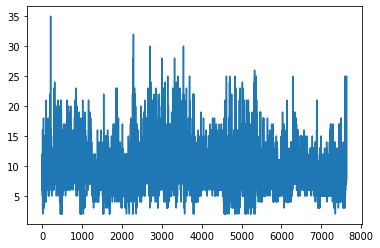

In [151]:
max_lens = list()
for row in new_data:
    max_lens.append(len(row))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

In [152]:
biluo_labels[0], new_data[0]

(['B-Rating', 'L-Rating', 'O', 'O', 'B-Amenity', 'L-Amenity'],
 ['2', 'start', 'restaurants', 'with', 'inside', 'dining'])

In [153]:
import json
from collections import Counter
from tqdm.notebook import tqdm
import joblib
from typing import List, Tuple, Union, Dict

#### Task 5

create two variables, that will contains mappings between entities and indices. Each dictionary must include entities: `O` and `PAD`.
Initialize variable `tag_to_idx`.

In [154]:
# YOUR CODE HERE

tags = sorted(list({i for j in biluo_labels for i in j}) +['PAD'])

tag_to_idx = {k: v for k, v in zip(tags, range(0, len(tags)))}

with open('mapping.json', 'w') as f:
  json.dump(tag_to_idx, f)

idx_to_tag = {second: first for first, second in tag_to_idx.items()}

tag_to_idx

{'B-Amenity': 0,
 'B-Cuisine': 1,
 'B-Dish': 2,
 'B-Hours': 3,
 'B-Location': 4,
 'B-Price': 5,
 'B-Rating': 6,
 'B-Restaurant_Name': 7,
 'I-Amenity': 8,
 'I-Cuisine': 9,
 'I-Dish': 10,
 'I-Hours': 11,
 'I-Location': 12,
 'I-Price': 13,
 'I-Rating': 14,
 'I-Restaurant_Name': 15,
 'L-Amenity': 16,
 'L-Cuisine': 17,
 'L-Dish': 18,
 'L-Hours': 19,
 'L-Location': 20,
 'L-Price': 21,
 'L-Rating': 22,
 'L-Restaurant_Name': 23,
 'O': 24,
 'PAD': 25,
 'U-Amenity': 26,
 'U-Cuisine': 27,
 'U-Dish': 28,
 'U-Hours': 29,
 'U-Location': 30,
 'U-Price': 31,
 'U-Rating': 32,
 'U-Restaurant_Name': 33}

In [155]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
    
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

#### Task 6

Count how many unique words are there in our train dataset. Parameters `min_words` and `max_words` should be initialized as default values. Initialize variable `word_to_idx` from method `get_word_to_idx`.

##### help

In [156]:
# 1. first you can count occurences of each word
# 2. second you can pass list of tuples for each pair (word, num_of_occurencies) to function get_word_to_idx

##### Continue work

In [157]:
count = Counter([i for j in new_data for i in j])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1)
len(word_to_idx)

3805

In [158]:
assert len(word_to_idx) == 3805

In [159]:
def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row))
          text = row[:trim_length]
          texts[ind, :trim_length] = [word2index[item.lower()] for item in text]
    return texts

def create_matrix_of_tags(dataset, max_sequence_length, pad_index, tag2idx):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row))
          labels = row[: trim_length]
          tags[ind, : trim_length] = [tag2idx[item] for item in labels]
    return tags

In [160]:
texts = create_matrix_of_texts(new_data, 
                               int(max_lens.quantile(0.97)),
                               '<pad>', word_to_idx)

tags = create_matrix_of_tags(biluo_labels,
                             int(max_lens.quantile(0.97)),
                             tag_to_idx['PAD'],
                             tag_to_idx)

In [161]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [162]:
ner_dataset = NerDataset(texts, tags)
assert len(ner_dataset) == 7634

In [163]:
from torch.utils.data.dataset import random_split

In [164]:
BATCH_SIZE = 32

#### Task 8

Initialize dataloaders for train and validation. There is no need to shuffle validation dataloader, but it is better to shuffle train and drop last batch from train dataloader.

In [165]:
# YOUR CODE HERE

num_train = int(len(ner_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])



train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False)

In this toy example we will first try simple FCNN for your problem. Let's look how bad/good it fits our data.

#### Task 9

Initialize sequantial layers of our FCNN

In [166]:
# YOUR CODE HERE

class NerModel(nn.Module):
    def __init__(
        self,
        word2idx: Dict,
        embedding_dim: int = 100,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256,
    ):
        super(NerModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')
        self.word2idx = word2idx
        self.labels = mapping

        self.linear_sigmoid_stack = nn.Sequential(
            nn.Embedding(len(self.word2idx), embedding_dim, ),
            nn.Sigmoid(),
            nn.Linear(embedding_dim, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, len(mapping))
        )

    def forward(self, tokens: LongTensor) -> FloatTensor:

        return self.linear_sigmoid_stack(tokens).view(-1, len(self.labels))

Now we will create basic network and check how it calculate loss.

In [167]:
model = NerModel(word_to_idx, 100, {idx: str(idx) for idx in range(10)})
assert (
        len(list(name for name, module in model.named_modules())) > 3
    ), "Not enough layers created"

In [168]:
num_classes = len(tag_to_idx)
model = NerModel(word_to_idx, 30, {idx: str(idx) for idx in range(num_classes)})
seq_len = 32
example_input = torch.randint(0, 2, (BATCH_SIZE, seq_len), dtype=torch.int64)
logits = model(example_input)
assert isinstance(logits, torch.FloatTensor)
assert logits.shape == (BATCH_SIZE * seq_len, num_classes), f"current size of model output {logits.shape}"

In [169]:
i = iter(train_dataloader)
text, label = next(i)
logits = model(text)
loss_function = nn.CrossEntropyLoss()
loss_function(logits, label.view(-1))

tensor(3.8783, grad_fn=<NllLossBackward>)

Everything looks pretty well and seems correct. Lets now write evaluation function and begin our training.

#### Task 10

Fill lines of code. First you need to initialize variable of `correct_labels` (labels, that are not special ones). Then you need to get `true_labels` and `predicted` variables.

In [200]:
# YOUR CODE HERE
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in idx_to_tag.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               int(max_lens.quantile(0.97)),
                                                               len(tag_to_idx)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    true_labels = [idx_to_tag[val] for val in true_labels]
    
    predicted = [idx_to_tag[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

Now we can create our model and start trainig

In [197]:
model = NerModel(word_to_idx, 300, tag_to_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerModel(
  (linear_sigmoid_stack): Sequential(
    (0): Embedding(3805, 300)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=34, bias=True)
  )
)

In [203]:
for e in range(10):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
evaluate(valid_dataloader)

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 0, loss: 0.2920


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 1, loss: 0.2894


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 2, loss: 0.2889


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 3, loss: 0.2870


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 4, loss: 0.2859


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 5, loss: 0.2847


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 6, loss: 0.2840


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 7, loss: 0.2830


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 8, loss: 0.2823


  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 9, loss: 0.2816

                    precision    recall  f1-score   support

        B-Amenity       0.60      0.45      0.51        92
        B-Cuisine       0.79      0.28      0.41        40
           B-Dish       0.85      0.52      0.65        21
          B-Hours       0.74      0.54      0.62        26
       B-Location       0.65      0.65      0.65        93
          B-Price       1.00      0.10      0.18        10
         B-Rating       0.64      0.35      0.45        20
B-Restaurant_Name       0.61      0.60      0.61        50
        I-Amenity       0.60      0.06      0.11        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.00      0.00      0.00         7
          I-Hours       0.62      0.53      0.57        30
       I-Location       0.35      0.39      0.37        57
          I-Price       0.00      0.00      0.00         7
         I-Rating       1.00      0.40      0.57         5
I-Restaurant_Name       0.36 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We did it, but quality of model is rather bad. Now you can try RNNs.

### RNNs

All process from FCNN works fine, but we need to use new architecture. Let's write new model, that process data and uses some kind of Recurrent Neural Network.

#### Task 11

Fill missing layers of model. You can use any RNN.

In [204]:
# YOUR CODE HERE

class NerRNNModel(nn.Module):
    def __init__(
        self,
        word2idx: Dict,
        embedding_dim: int = 100,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')
        self.word2idx = word2idx
        self.labels = mapping
        self.embedding = nn.Embedding(len(word_to_idx), embedding_dim)
        self.encoder = nn.RNN(
            embedding_dim,
            hidden_size,
            batch_first=True
        )
        self.projection = nn.Linear(hidden_size, len(mapping))

    def forward(self, tokens: LongTensor) -> FloatTensor:

        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

Now we can duplicate all cells from above and simply just start new iteration of training new model.

In [205]:
model = NerRNNModel(word_to_idx, 100, {idx: str(idx) for idx in range(10)})
assert (
        len(list(name for name, module in model.named_modules())) > 3
    ), "Not enough layers created"

In [206]:
num_classes = len(tag_to_idx)
model = NerRNNModel(word_to_idx, 30, {idx: str(idx) for idx in range(num_classes)})
seq_len = 32
example_input = torch.randint(0, 2, (BATCH_SIZE, seq_len), dtype=torch.int64)
logits = model(example_input)
assert isinstance(logits, torch.FloatTensor)
assert logits.shape == (BATCH_SIZE * seq_len, num_classes), f"current size of model output {logits.shape}"

In [207]:
i = iter(train_dataloader)
text, label = next(i)
logits = model(text)
loss_function = nn.CrossEntropyLoss()
loss_function(logits, label.view(-1))

tensor(3.5380, grad_fn=<NllLossBackward>)

In [208]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in idx_to_tag.values() if value != 'O' and value != 'PAD']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               int(max_lens.quantile(0.97)),
                                                               len(tag_to_idx)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [idx_to_tag[val] for val in true_labels]
    
    predicted = [idx_to_tag[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [209]:
idx_to_tag

{0: 'B-Amenity',
 1: 'B-Cuisine',
 2: 'B-Dish',
 3: 'B-Hours',
 4: 'B-Location',
 5: 'B-Price',
 6: 'B-Rating',
 7: 'B-Restaurant_Name',
 8: 'I-Amenity',
 9: 'I-Cuisine',
 10: 'I-Dish',
 11: 'I-Hours',
 12: 'I-Location',
 13: 'I-Price',
 14: 'I-Rating',
 15: 'I-Restaurant_Name',
 16: 'L-Amenity',
 17: 'L-Cuisine',
 18: 'L-Dish',
 19: 'L-Hours',
 20: 'L-Location',
 21: 'L-Price',
 22: 'L-Rating',
 23: 'L-Restaurant_Name',
 24: 'O',
 25: 'PAD',
 26: 'U-Amenity',
 27: 'U-Cuisine',
 28: 'U-Dish',
 29: 'U-Hours',
 30: 'U-Location',
 31: 'U-Price',
 32: 'U-Rating',
 33: 'U-Restaurant_Name'}

In [210]:
model = NerRNNModel(word_to_idx, 300, tag_to_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerRNNModel(
  (embedding): Embedding(3805, 300)
  (encoder): RNN(300, 256, batch_first=True)
  (projection): Linear(in_features=256, out_features=34, bias=True)
)

In [211]:
sum([params.numel() for params in model.parameters() if params.requires_grad])

1293086

In [213]:
for e in range(10):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 0, loss: 0.2197

                    precision    recall  f1-score   support

        B-Amenity       0.70      0.48      0.57        92
        B-Cuisine       0.54      0.47      0.51        40
           B-Dish       0.50      0.43      0.46        21
          B-Hours       0.58      0.73      0.64        26
       B-Location       0.65      0.74      0.69        93
          B-Price       0.17      0.10      0.12        10
         B-Rating       0.52      0.65      0.58        20
B-Restaurant_Name       0.67      0.60      0.63        50
        I-Amenity       0.27      0.20      0.23        50
        I-Cuisine       0.22      0.33      0.27         6
           I-Dish       0.33      0.57      0.42         7
          I-Hours       0.82      0.60      0.69        30
       I-Location       0.51      0.68      0.59        57
          I-Price       0.00      0.00      0.00         7
         I-Rating       0.17      0.20      0.18         5
I-Restaurant_Name       0.48 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 1, loss: 0.2178

                    precision    recall  f1-score   support

        B-Amenity       0.61      0.73      0.66        92
        B-Cuisine       0.67      0.35      0.46        40
           B-Dish       0.45      0.48      0.47        21
          B-Hours       0.72      0.69      0.71        26
       B-Location       0.61      0.76      0.68        93
          B-Price       0.50      0.30      0.37        10
         B-Rating       0.52      0.55      0.54        20
B-Restaurant_Name       0.59      0.66      0.62        50
        I-Amenity       0.29      0.22      0.25        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.14      0.14      0.14         7
          I-Hours       0.89      0.57      0.69        30
       I-Location       0.59      0.77      0.67        57
          I-Price       0.40      0.29      0.33         7
         I-Rating       0.40      0.40      0.40         5
I-Restaurant_Name       0.69 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 2, loss: 0.2188

                    precision    recall  f1-score   support

        B-Amenity       0.63      0.61      0.62        92
        B-Cuisine       0.40      0.35      0.37        40
           B-Dish       0.40      0.38      0.39        21
          B-Hours       0.79      0.58      0.67        26
       B-Location       0.59      0.74      0.66        93
          B-Price       1.00      0.10      0.18        10
         B-Rating       0.46      0.55      0.50        20
B-Restaurant_Name       0.68      0.46      0.55        50
        I-Amenity       0.40      0.08      0.13        50
        I-Cuisine       0.25      0.17      0.20         6
           I-Dish       0.29      0.29      0.29         7
          I-Hours       0.69      0.60      0.64        30
       I-Location       0.69      0.63      0.66        57
          I-Price       0.00      0.00      0.00         7
         I-Rating       0.17      0.20      0.18         5
I-Restaurant_Name       0.55 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 3, loss: 0.2151

                    precision    recall  f1-score   support

        B-Amenity       0.59      0.60      0.59        92
        B-Cuisine       0.53      0.40      0.46        40
           B-Dish       0.37      0.62      0.46        21
          B-Hours       0.85      0.65      0.74        26
       B-Location       0.53      0.82      0.64        93
          B-Price       0.43      0.30      0.35        10
         B-Rating       0.53      0.45      0.49        20
B-Restaurant_Name       0.56      0.62      0.59        50
        I-Amenity       0.41      0.14      0.21        50
        I-Cuisine       0.14      0.17      0.15         6
           I-Dish       0.27      0.57      0.36         7
          I-Hours       0.80      0.67      0.73        30
       I-Location       0.54      0.67      0.60        57
          I-Price       0.40      0.29      0.33         7
         I-Rating       0.29      0.40      0.33         5
I-Restaurant_Name       0.70 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 4, loss: 0.2148

                    precision    recall  f1-score   support

        B-Amenity       0.65      0.64      0.64        92
        B-Cuisine       0.49      0.42      0.45        40
           B-Dish       0.44      0.38      0.41        21
          B-Hours       0.82      0.69      0.75        26
       B-Location       0.65      0.76      0.70        93
          B-Price       0.22      0.20      0.21        10
         B-Rating       0.47      0.45      0.46        20
B-Restaurant_Name       0.52      0.66      0.58        50
        I-Amenity       0.31      0.20      0.24        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.22      0.29      0.25         7
          I-Hours       0.83      0.67      0.74        30
       I-Location       0.64      0.61      0.62        57
          I-Price       0.33      0.29      0.31         7
         I-Rating       0.00      0.00      0.00         5
I-Restaurant_Name       0.75 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 5, loss: 0.2155

                    precision    recall  f1-score   support

        B-Amenity       0.68      0.54      0.61        92
        B-Cuisine       0.58      0.35      0.44        40
           B-Dish       0.48      0.57      0.52        21
          B-Hours       0.70      0.73      0.72        26
       B-Location       0.71      0.71      0.71        93
          B-Price       0.25      0.30      0.27        10
         B-Rating       0.41      0.70      0.52        20
B-Restaurant_Name       0.48      0.60      0.54        50
        I-Amenity       0.24      0.16      0.19        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.22      0.29      0.25         7
          I-Hours       0.73      0.63      0.68        30
       I-Location       0.76      0.51      0.61        57
          I-Price       0.14      0.14      0.14         7
         I-Rating       0.12      0.20      0.15         5
I-Restaurant_Name       0.43 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 6, loss: 0.2179

                    precision    recall  f1-score   support

        B-Amenity       0.65      0.48      0.55        92
        B-Cuisine       0.57      0.42      0.49        40
           B-Dish       0.53      0.43      0.47        21
          B-Hours       0.80      0.62      0.70        26
       B-Location       0.69      0.66      0.67        93
          B-Price       0.22      0.20      0.21        10
         B-Rating       0.39      0.60      0.47        20
B-Restaurant_Name       0.55      0.60      0.57        50
        I-Amenity       0.42      0.22      0.29        50
        I-Cuisine       0.40      0.33      0.36         6
           I-Dish       0.18      0.29      0.22         7
          I-Hours       0.83      0.67      0.74        30
       I-Location       0.70      0.53      0.60        57
          I-Price       0.50      0.29      0.36         7
         I-Rating       0.25      0.20      0.22         5
I-Restaurant_Name       0.50 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 7, loss: 0.2213

                    precision    recall  f1-score   support

        B-Amenity       0.55      0.55      0.55        92
        B-Cuisine       0.56      0.38      0.45        40
           B-Dish       0.44      0.38      0.41        21
          B-Hours       0.63      0.73      0.68        26
       B-Location       0.67      0.63      0.65        93
          B-Price       0.33      0.40      0.36        10
         B-Rating       0.60      0.45      0.51        20
B-Restaurant_Name       0.65      0.56      0.60        50
        I-Amenity       0.29      0.14      0.19        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.31      0.71      0.43         7
          I-Hours       0.83      0.63      0.72        30
       I-Location       0.59      0.53      0.56        57
          I-Price       0.33      0.14      0.20         7
         I-Rating       0.25      0.20      0.22         5
I-Restaurant_Name       0.40 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 8, loss: 0.2218

                    precision    recall  f1-score   support

        B-Amenity       0.71      0.46      0.56        92
        B-Cuisine       0.41      0.42      0.42        40
           B-Dish       0.63      0.57      0.60        21
          B-Hours       0.75      0.69      0.72        26
       B-Location       0.56      0.74      0.64        93
          B-Price       0.25      0.10      0.14        10
         B-Rating       0.47      0.80      0.59        20
B-Restaurant_Name       0.52      0.62      0.56        50
        I-Amenity       0.24      0.16      0.19        50
        I-Cuisine       0.00      0.00      0.00         6
           I-Dish       0.25      0.29      0.27         7
          I-Hours       0.65      0.73      0.69        30
       I-Location       0.48      0.70      0.57        57
          I-Price       0.20      0.14      0.17         7
         I-Rating       1.00      0.20      0.33         5
I-Restaurant_Name       0.64 

  0%|          | 0/226 [00:00<?, ?it/s]


Epoch: 9, loss: 0.2213

                    precision    recall  f1-score   support

        B-Amenity       0.71      0.50      0.59        92
        B-Cuisine       0.56      0.23      0.32        40
           B-Dish       0.30      0.43      0.35        21
          B-Hours       0.70      0.73      0.72        26
       B-Location       0.64      0.75      0.69        93
          B-Price       0.25      0.10      0.14        10
         B-Rating       0.52      0.85      0.64        20
B-Restaurant_Name       0.51      0.64      0.57        50
        I-Amenity       0.29      0.10      0.15        50
        I-Cuisine       0.14      0.17      0.15         6
           I-Dish       0.18      0.29      0.22         7
          I-Hours       0.75      0.70      0.72        30
       I-Location       0.58      0.67      0.62        57
          I-Price       0.25      0.14      0.18         7
         I-Rating       0.50      0.20      0.29         5
I-Restaurant_Name       0.53 

Futher working:
- Try more complex architecture
- try bidirectional rnns
- try other hyperparameters
- try pretrained embeddings